## Import Libraries

[Pytorch](//pytorch.org/) is used to construct the CNN, while [livelossplot](//github.com/stared/livelossplot) and [matplotlib](//matplotlib.org/) are used to draw the graph. 

In [1]:
from __future__ import print_function

import sys
import argparse
import importlib
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

from livelossplot import PlotLosses
import matplotlib.pyplot as plt

## Main Function and Utilities

This section contains reusable functions for model training and graph plotting

The [Conv2D](//pytorch.org/docs/master/generated/torch.nn.Conv2d.html) function is defined as [1]:

* Input: $ (N, C_{in}, H_{in}, W_{in}) $
* Output: $ (N, C_{out},H_{out},W_{out}) $

$$
H_{out}= ⌊\frac{H_{in}+2*padding[0]-dilation[0]*(kernel\_size[0]-1)-1}{stride[0]}+1⌋
$$

$$
W_{out}= ⌊\frac{W_{in}+2*padding[1]-dilation[1]*(kernel\_size[1]-1)-1}{stride[1]}+1⌋
$$

In [2]:
def train(args, model, device, train_loader, func_loss, optimizer, epoch, logs):
    model.train()
    training_loss = 0.0
    training_corrects = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = func_loss(output, target)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(output, 1)
        training_loss += loss.detach() * data.size(0)
        training_corrects += torch.sum(preds == target.data)
        if batch_idx % args.log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.4f}%)]\tLoss: {loss.item():.6f}')
            if args.dry_run:
                break
    epoch_loss = training_loss / len(train_loader.dataset)
    epoch_acc = training_corrects.float() / len(train_loader.dataset)
    logs['log loss'] = epoch_loss.item()
    logs['accuracy'] = epoch_acc.item()


def test(model, device, test_loader, func_loss, logs):
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = func_loss(output, target)
            test_loss += loss.detach() * data.size(0)
            _, preds = torch.max(output, 1)
            test_corrects += torch.sum(preds == target.data)

    epoch_loss = test_loss / len(test_loader.dataset)
    epoch_acc = test_corrects.float() / len(test_loader.dataset)
    logs['val_log loss'] = epoch_loss.item()
    logs['val_accuracy'] = epoch_acc.item()
    print(f'\nTest set: Average loss: {epoch_loss:.4f}, Accuracy: {test_corrects}/{len(test_loader.dataset)} ({100. * epoch_acc:.4f}%)\n')


def show_prediction(model, device, test_loader, func_loss, positive, row=4, col=4, fig_size=None):
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += func_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Store wrongly predicted images
            idx = (pred == target.view_as(pred)).nonzero()[:, 0] if positive \
                else (pred != target.view_as(pred)).nonzero()[:, 0]
            samples = data[idx]
            preds = pred[idx]
            truths = target.view_as(pred)[idx]

            for i in range(len(idx)):
                results.append((
                    samples[i],
                    preds[i].item(),
                    truths[i].item()))

        try:
            result_rnd = random.sample(results, row * col)
        except ValueError:
            result_rnd = results

        f, axarr = plt.subplots(row, col, figsize=(fig_size))
        for c in range(col):
            for r in range(row):
                if len(result_rnd) > 0:
                    result = result_rnd.pop()
                    axarr[r, c].imshow(result[0].cpu().numpy().squeeze(), cmap="gray_r")
                    axarr[r, c].set_title(f'{result[1]}' if positive else f'{result[1]} ({result[2]})')
                axarr[r, c].axis('off')
        plt.tight_layout()
        plt.show()

        if positive:
            print(f'\nCorrect prediction: {correct}/{len(test_loader.dataset)} ({100.0 * correct / len(test_loader.dataset):.2f}%)\n')
        else:
            print(f'\nWrong prediction: {len(test_loader.dataset) - correct}/{len(test_loader.dataset)} ({100.0 - 100.0 * correct / len(test_loader.dataset):.2f}%)\n')

def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    parser.add_argument('--net', type=str, default="ExampleNet",
                        help='File name of the network')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset1 = datasets.MNIST('./data', train=True, download=True,
                              transform=transform)
    dataset2 = datasets.MNIST('./data', train=False,
                              transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    NetClass = globals().get(args.net) or getattr(importlib.import_module(args.net), args.net)
    model = NetClass().to(device)
    func_loss = F.nll_loss
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    liveloss = PlotLosses()

    for epoch in range(1, args.epochs + 1):
        logs = {}
        train(args, model, device, train_loader, func_loss, optimizer, epoch, logs)
        test(model, device, test_loader, func_loss, logs)
        scheduler.step()
        liveloss.update(logs)
        liveloss.send()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    show_prediction(model, device, test_loader, func_loss, True, 8, 8, (8, 8))
    show_prediction(model, device, test_loader, func_loss, False, 8, 8, (8, 8))


## Define Networks

The following CNN is provided by [Pytorch examples](//github.com/pytorch/examples/blob/master/mnist/main.py) on GitHub.

The network used is defined as `1x28x28-32C3-64C3-MP2-128N-10N`

Following graph shows the structure of the neural network:

![default nn](data:image/svg+xml,%3Csvg%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20width%3D%221740%22%20height%3D%22958%22%20style%3D%22cursor%3A%20move%3B%22%3E%3Crect%20width%3D%22100%25%22%20height%3D%22100%25%22%20fill%3D%22white%22%2F%3E%3Cg%20transform%3D%22translate%28-1368.2148867289434%2C-528.2874998857069%29%20scale%281.937236378453257%29%22%3E%3Crect%20class%3D%22rect%22%20id%3D%220_0%22%20width%3D%2228%22%20height%3D%2228%22%20x%3D%22736%22%20y%3D%22472.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_0%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22804%22%20y%3D%22413.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_1%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22812%22%20y%3D%22421.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_2%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22820%22%20y%3D%22429.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_3%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22828%22%20y%3D%22437.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_4%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22836%22%20y%3D%22445.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_5%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22844%22%20y%3D%22453.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_6%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22852%22%20y%3D%22461.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_7%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22860%22%20y%3D%22469.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_8%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22868%22%20y%3D%22477.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_9%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22876%22%20y%3D%22485.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_10%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22884%22%20y%3D%22493.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_11%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22892%22%20y%3D%22501.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_12%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22900%22%20y%3D%22509.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_13%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22908%22%20y%3D%22517.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_14%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22916%22%20y%3D%22525.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_15%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22924%22%20y%3D%22533.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_0%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22960%22%20y%3D%22350.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_1%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22968%22%20y%3D%22358.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_2%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22976%22%20y%3D%22366.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_3%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22984%22%20y%3D%22374.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_4%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22992%22%20y%3D%22382.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_5%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221000%22%20y%3D%22390.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_6%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221008%22%20y%3D%22398.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_7%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221016%22%20y%3D%22406.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_8%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221024%22%20y%3D%22414.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_9%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221032%22%20y%3D%22422.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_10%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221040%22%20y%3D%22430.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_11%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221048%22%20y%3D%22438.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_12%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221056%22%20y%3D%22446.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_13%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221064%22%20y%3D%22454.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_14%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221072%22%20y%3D%22462.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_15%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221080%22%20y%3D%22470.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_16%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221088%22%20y%3D%22478.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_17%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221096%22%20y%3D%22486.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_18%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221104%22%20y%3D%22494.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_19%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221112%22%20y%3D%22502.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_20%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221120%22%20y%3D%22510.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_21%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221128%22%20y%3D%22518.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_22%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221136%22%20y%3D%22526.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_23%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221144%22%20y%3D%22534.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_24%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221152%22%20y%3D%22542.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_25%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221160%22%20y%3D%22550.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_26%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221168%22%20y%3D%22558.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_27%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221176%22%20y%3D%22566.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_28%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221184%22%20y%3D%22574.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_29%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221192%22%20y%3D%22582.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_30%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221200%22%20y%3D%22590.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_31%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%221208%22%20y%3D%22598.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_0%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221212%22%20y%3D%22356.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_1%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221220%22%20y%3D%22364.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_2%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221228%22%20y%3D%22372.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_3%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221236%22%20y%3D%22380.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_4%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221244%22%20y%3D%22388.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_5%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221252%22%20y%3D%22396.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_6%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221260%22%20y%3D%22404.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_7%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221268%22%20y%3D%22412.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_8%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221276%22%20y%3D%22420.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_9%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221284%22%20y%3D%22428.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_10%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221292%22%20y%3D%22436.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_11%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221300%22%20y%3D%22444.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_12%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221308%22%20y%3D%22452.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_13%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221316%22%20y%3D%22460.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_14%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221324%22%20y%3D%22468.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_15%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221332%22%20y%3D%22476.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_16%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221340%22%20y%3D%22484.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_17%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221348%22%20y%3D%22492.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_18%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221356%22%20y%3D%22500.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_19%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221364%22%20y%3D%22508.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_20%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221372%22%20y%3D%22516.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_21%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221380%22%20y%3D%22524.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_22%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221388%22%20y%3D%22532.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_23%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221396%22%20y%3D%22540.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_24%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221404%22%20y%3D%22548.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_25%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221412%22%20y%3D%22556.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_26%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221420%22%20y%3D%22564.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_27%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221428%22%20y%3D%22572.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_28%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221436%22%20y%3D%22580.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_29%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221444%22%20y%3D%22588.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_30%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221452%22%20y%3D%22596.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_31%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%221460%22%20y%3D%22604.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22conv%22%20id%3D%22conv_0%22%20width%3D%228%22%20height%3D%228%22%20x%3D%22747.5818168890013%22%20y%3D%22484.57694216908396%22%20style%3D%22fill-opacity%3A%200%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22conv%22%20id%3D%22conv_1%22%20width%3D%228%22%20height%3D%228%22%20x%3D%22935.9562763744509%22%20y%3D%22542.2406478684785%22%20style%3D%22fill-opacity%3A%200%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22conv%22%20id%3D%22conv_2%22%20width%3D%221%22%20height%3D%221%22%20x%3D%221214.965991196629%22%20y%3D%22612.5153740680773%22%20style%3D%22fill-opacity%3A%200%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_0%22%20x1%3D%22755.5818168890013%22%20y1%3D%22492.57694216908396%22%20x2%3D%22939.0563619557016%22%20y2%3D%22549.2000248198092%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_0%22%20x1%3D%22755.5818168890013%22%20y1%3D%22484.57694216908396%22%20x2%3D%22939.0563619557016%22%20y2%3D%22549.2000248198092%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_1%22%20x1%3D%22943.9562763744509%22%20y1%3D%22550.2406478684785%22%20x2%3D%221223.9417018326012%22%20y2%3D%22610.1541971579713%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_1%22%20x1%3D%22943.9562763744509%22%20y1%3D%22542.2406478684785%22%20x2%3D%221223.9417018326012%22%20y2%3D%22610.1541971579713%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_2%22%20x1%3D%221215.965991196629%22%20y1%3D%22613.5153740680773%22%20x2%3D%221463.6344301895456%22%20y2%3D%22611.8123690789969%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_2%22%20x1%3D%221215.965991196629%22%20y1%3D%22612.5153740680773%22%20x2%3D%221463.6344301895456%22%20y2%3D%22611.8123690789969%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cpolygon%20class%3D%22poly%22%20id%3D%22fc_0%22%20points%3D%221452%2C441.24516600406093%201462%2C441.24516600406093%201552.5096679918781%2C531.754833995939%201542.5096679918781%2C531.754833995939%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Fpolygon%3E%3Cpolygon%20class%3D%22poly%22%20id%3D%22fc_1%22%20points%3D%221554.5096679918781%2C482.96446609406723%201564.5096679918781%2C482.96446609406723%201571.5807358037437%2C490.0355339059327%201561.5807358037437%2C490.0355339059327%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Fpolygon%3E%3Cline%20class%3D%22line%22%20id%3D%22fc_0%22%20x1%3D%221472%22%20y1%3D%22616.5%22%20x2%3D%221542.5096679918781%22%20y2%3D%22531.7548339959391%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22line%22%20id%3D%22fc_0%22%20x1%3D%221224%22%20y1%3D%22356.5%22%20x2%3D%221452%22%20y2%3D%22441.24516600406093%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22line%22%20id%3D%22fc_1%22%20x1%3D%221552.5096679918781%22%20y1%3D%22531.7548339959391%22%20x2%3D%221561.5807358037437%22%20y2%3D%22490.03553390593277%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22line%22%20id%3D%22fc_1%22%20x1%3D%221462%22%20y1%3D%22441.24516600406093%22%20x2%3D%221554.5096679918781%22%20y2%3D%22482.96446609406723%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Ctext%20class%3D%22text%22%20dy%3D%22.35em%22%20font-family%3D%22sans-serif%22%20x%3D%22805.5%22%20y%3D%22744.5%22%20style%3D%22font-size%3A%2016px%3B%22%3EConvolution%3C%2Ftext%3E%3Ctext%20class%3D%22text%22%20dy%3D%22.35em%22%20font-family%3D%22sans-serif%22%20x%3D%221008%22%20y%3D%22744.5%22%20style%3D%22font-size%3A%2016px%3B%22%3EConvolution%3C%2Ftext%3E%3Ctext%20class%3D%22text%22%20dy%3D%22.35em%22%20font-family%3D%22sans-serif%22%20x%3D%221272%22%20y%3D%22744.5%22%20style%3D%22font-size%3A%2016px%3B%22%3EMax-Pool%3C%2Ftext%3E%3Ctext%20class%3D%22text%22%20dy%3D%22.35em%22%20font-family%3D%22sans-serif%22%20x%3D%221469.6274169979695%22%20y%3D%22744.5%22%20style%3D%22font-size%3A%2016px%3B%22%3EDense%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%22736%22%20y%3D%22457.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E28x28%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%22804%22%20y%3D%22398.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E32%4026x26%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%22960%22%20y%3D%22335.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E64%4024x24%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%221212%22%20y%3D%22341.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E64%4012x12%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%221452%22%20y%3D%22426.24516600406093%22%20style%3D%22font-size%3A%2016px%3B%22%3E1x128%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%221554.5096679918781%22%20y%3D%22467.96446609406723%22%20style%3D%22font-size%3A%2016px%3B%22%3E1x10%3C%2Ftext%3E%3C%2Fg%3E%3C%2Fsvg%3E "Default NN Structure")

In [3]:
class ExampleNet(nn.Module):
    def __init__(self):
        super(ExampleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)  # [1, 28, 28] -> [32, 26, 26]
        x = F.relu(x)
        x = self.conv2(x)  # [32, 26, 26] -> [64, 24, 24]
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # [64, 24, 24] -> [64, 12, 12]
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # [64, 12, 12] -> [9216]
        x = self.fc1(x)  # [9216] -> [128]
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)  # [128] -> [10]
        output = F.log_softmax(x, dim=1)
        return output

## Training

The CNN is trained uses [NLL loss(negative likelihood loss)](//pytorch.org/docs/master/generated/torch.nn.NLLLoss.html?highlight=nll#nllloss) function [2]. 

$$
l(x, y)=L=\{l_1,...,l_N\}^T, l_n=-w_{y_n}x_{n,y_n}, w_c=weight[c]\cdot1\{c\neq ignore\_index\}
$$

By default, the NLL loss is reduced with weighted mean function:

$$
l(x, y) = \Sigma_{n=1}^{N}\frac{1}{\Sigma_{n=1}^{N}w_{y_n}}l_n
$$

The training takes a batch size of 128 and epochs of 14. 

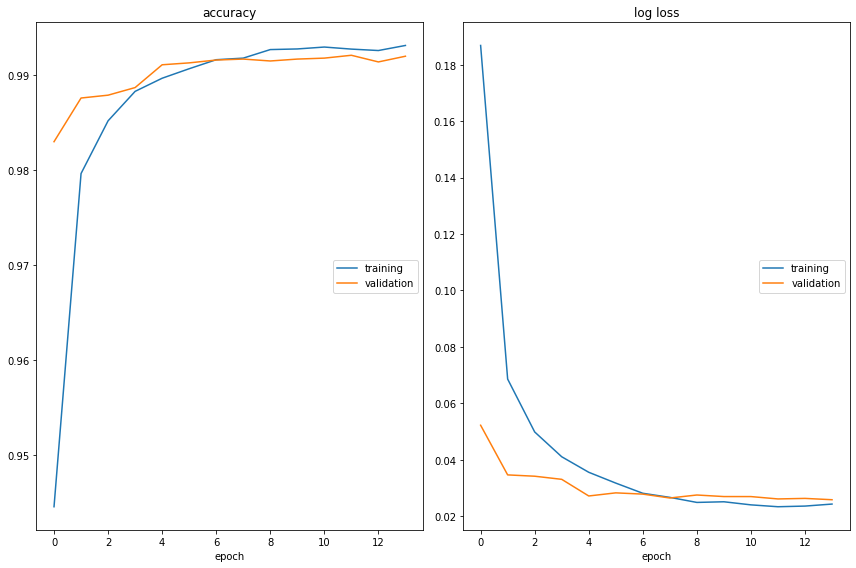

accuracy
	training         	 (min:    0.945, max:    0.993, cur:    0.993)
	validation       	 (min:    0.983, max:    0.992, cur:    0.992)
log loss
	training         	 (min:    0.023, max:    0.187, cur:    0.024)
	validation       	 (min:    0.026, max:    0.052, cur:    0.026)


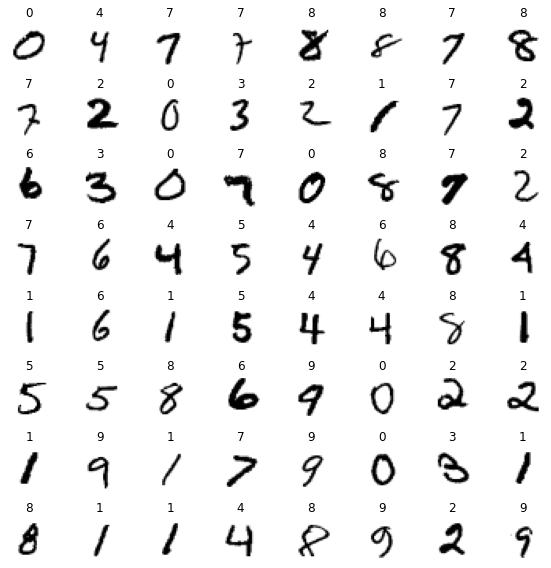


Correct prediction: 9920/10000 (99.20%)



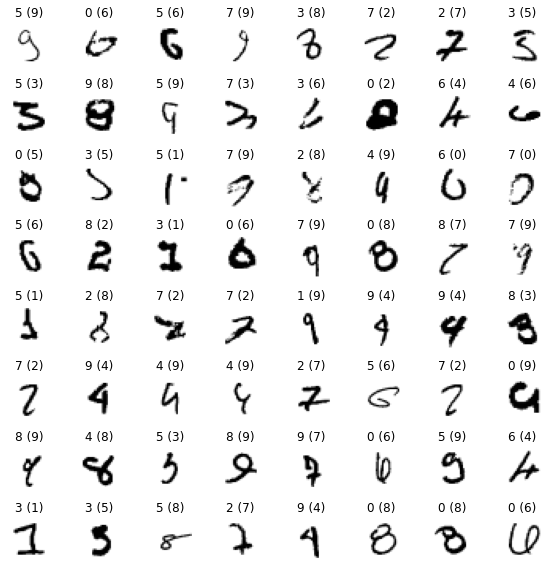


Wrong prediction: 80/10000 (0.80%)



In [4]:
sys.argv = ["", "--net=ExampleNet"]
main()

The above images illustrate the prediction of the trained model using the test dataset. Shown predicts are randomly selected from the output results. The first image shows the correct prediction, while the second image show the wrong ones. The numbers in the round brackets are the correct label. 

## Tuning the Network

An alternate network structure is defined as `1x28x28-32C3-32C3-MP2-64C3-64C3-MP2-128N-10N`, shows in the following graph:

![my_nn](data:image/svg+xml,%3Csvg%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20width%3D%222560%22%20height%3D%22913%22%20style%3D%22cursor%3A%20move%3B%22%3E%3Crect%20width%3D%22100%25%22%20height%3D%22100%25%22%20fill%3D%22white%22%2F%3E%3Cg%20transform%3D%22translate%28-664.6033376068733%2C-556.3032788789901%29%20scale%282.0849315216822464%29%22%3E%3Crect%20class%3D%22rect%22%20id%3D%220_0%22%20width%3D%2228%22%20height%3D%2228%22%20x%3D%22377%22%20y%3D%22442.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_0%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22473%22%20y%3D%22383.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_1%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22481%22%20y%3D%22391.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_2%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22489%22%20y%3D%22399.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_3%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22497%22%20y%3D%22407.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_4%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22505%22%20y%3D%22415.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_5%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22513%22%20y%3D%22423.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_6%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22521%22%20y%3D%22431.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_7%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22529%22%20y%3D%22439.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_8%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22537%22%20y%3D%22447.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_9%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22545%22%20y%3D%22455.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_10%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22553%22%20y%3D%22463.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_11%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22561%22%20y%3D%22471.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_12%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22569%22%20y%3D%22479.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_13%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22577%22%20y%3D%22487.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_14%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22585%22%20y%3D%22495.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%221_15%22%20width%3D%2226%22%20height%3D%2226%22%20x%3D%22593%22%20y%3D%22503.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_0%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22625%22%20y%3D%22384.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_1%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22633%22%20y%3D%22392.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_2%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22641%22%20y%3D%22400.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_3%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22649%22%20y%3D%22408.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_4%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22657%22%20y%3D%22416.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_5%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22665%22%20y%3D%22424.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_6%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22673%22%20y%3D%22432.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_7%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22681%22%20y%3D%22440.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_8%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22689%22%20y%3D%22448.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_9%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22697%22%20y%3D%22456.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_10%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22705%22%20y%3D%22464.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_11%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22713%22%20y%3D%22472.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_12%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22721%22%20y%3D%22480.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_13%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22729%22%20y%3D%22488.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_14%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22737%22%20y%3D%22496.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%222_15%22%20width%3D%2224%22%20height%3D%2224%22%20x%3D%22745%22%20y%3D%22504.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_0%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22749%22%20y%3D%22390.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_1%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22757%22%20y%3D%22398.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_2%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22765%22%20y%3D%22406.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_3%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22773%22%20y%3D%22414.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_4%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22781%22%20y%3D%22422.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_5%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22789%22%20y%3D%22430.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_6%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22797%22%20y%3D%22438.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_7%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22805%22%20y%3D%22446.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_8%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22813%22%20y%3D%22454.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_9%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22821%22%20y%3D%22462.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_10%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22829%22%20y%3D%22470.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_11%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22837%22%20y%3D%22478.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_12%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22845%22%20y%3D%22486.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_13%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22853%22%20y%3D%22494.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_14%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22861%22%20y%3D%22502.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%223_15%22%20width%3D%2212%22%20height%3D%2212%22%20x%3D%22869%22%20y%3D%22510.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_0%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22842%22%20y%3D%22327.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_1%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22850%22%20y%3D%22335.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_2%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22858%22%20y%3D%22343.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_3%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22866%22%20y%3D%22351.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_4%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22874%22%20y%3D%22359.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_5%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22882%22%20y%3D%22367.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_6%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22890%22%20y%3D%22375.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_7%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22898%22%20y%3D%22383.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_8%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22906%22%20y%3D%22391.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_9%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22914%22%20y%3D%22399.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_10%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22922%22%20y%3D%22407.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_11%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22930%22%20y%3D%22415.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_12%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22938%22%20y%3D%22423.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_13%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22946%22%20y%3D%22431.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_14%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22954%22%20y%3D%22439.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_15%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22962%22%20y%3D%22447.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_16%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22970%22%20y%3D%22455.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_17%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22978%22%20y%3D%22463.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_18%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22986%22%20y%3D%22471.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_19%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%22994%22%20y%3D%22479.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_20%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221002%22%20y%3D%22487.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_21%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221010%22%20y%3D%22495.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_22%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221018%22%20y%3D%22503.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_23%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221026%22%20y%3D%22511.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_24%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221034%22%20y%3D%22519.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_25%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221042%22%20y%3D%22527.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_26%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221050%22%20y%3D%22535.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_27%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221058%22%20y%3D%22543.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_28%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221066%22%20y%3D%22551.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_29%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221074%22%20y%3D%22559.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_30%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221082%22%20y%3D%22567.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%224_31%22%20width%3D%2210%22%20height%3D%2210%22%20x%3D%221090%22%20y%3D%22575.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_0%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221020%22%20y%3D%22328.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_1%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221028%22%20y%3D%22336.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_2%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221036%22%20y%3D%22344.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_3%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221044%22%20y%3D%22352.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_4%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221052%22%20y%3D%22360.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_5%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221060%22%20y%3D%22368.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_6%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221068%22%20y%3D%22376.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_7%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221076%22%20y%3D%22384.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_8%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221084%22%20y%3D%22392.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_9%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221092%22%20y%3D%22400.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_10%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221100%22%20y%3D%22408.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_11%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221108%22%20y%3D%22416.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_12%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221116%22%20y%3D%22424.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_13%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221124%22%20y%3D%22432.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_14%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221132%22%20y%3D%22440.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_15%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221140%22%20y%3D%22448.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_16%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221148%22%20y%3D%22456.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_17%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221156%22%20y%3D%22464.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_18%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221164%22%20y%3D%22472.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_19%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221172%22%20y%3D%22480.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_20%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221180%22%20y%3D%22488.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_21%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221188%22%20y%3D%22496.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_22%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221196%22%20y%3D%22504.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_23%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221204%22%20y%3D%22512.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_24%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221212%22%20y%3D%22520.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_25%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221220%22%20y%3D%22528.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_26%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221228%22%20y%3D%22536.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_27%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221236%22%20y%3D%22544.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_28%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221244%22%20y%3D%22552.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_29%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221252%22%20y%3D%22560.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_30%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221260%22%20y%3D%22568.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%225_31%22%20width%3D%228%22%20height%3D%228%22%20x%3D%221268%22%20y%3D%22576.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_0%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221184%22%20y%3D%22330.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_1%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221192%22%20y%3D%22338.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_2%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221200%22%20y%3D%22346.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_3%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221208%22%20y%3D%22354.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_4%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221216%22%20y%3D%22362.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_5%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221224%22%20y%3D%22370.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_6%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221232%22%20y%3D%22378.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_7%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221240%22%20y%3D%22386.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_8%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221248%22%20y%3D%22394.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_9%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221256%22%20y%3D%22402.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_10%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221264%22%20y%3D%22410.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_11%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221272%22%20y%3D%22418.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_12%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221280%22%20y%3D%22426.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_13%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221288%22%20y%3D%22434.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_14%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221296%22%20y%3D%22442.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_15%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221304%22%20y%3D%22450.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_16%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221312%22%20y%3D%22458.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_17%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221320%22%20y%3D%22466.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_18%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221328%22%20y%3D%22474.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_19%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221336%22%20y%3D%22482.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_20%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221344%22%20y%3D%22490.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_21%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221352%22%20y%3D%22498.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_22%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221360%22%20y%3D%22506.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_23%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221368%22%20y%3D%22514.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_24%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221376%22%20y%3D%22522.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_25%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221384%22%20y%3D%22530.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_26%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221392%22%20y%3D%22538.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_27%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221400%22%20y%3D%22546.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_28%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221408%22%20y%3D%22554.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_29%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221416%22%20y%3D%22562.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_30%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221424%22%20y%3D%22570.5%22%20style%3D%22fill%3A%20rgb%28160%2C%20160%2C%20160%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22rect%22%20id%3D%226_31%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221432%22%20y%3D%22578.5%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22conv%22%20id%3D%22conv_0%22%20width%3D%228%22%20height%3D%228%22%20x%3D%22384.66391087711463%22%20y%3D%22454.2367788075272%22%20style%3D%22fill-opacity%3A%200%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22conv%22%20id%3D%22conv_1%22%20width%3D%228%22%20height%3D%228%22%20x%3D%22597.566750422311%22%20y%3D%22513.4702768524356%22%20style%3D%22fill-opacity%3A%200%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22conv%22%20id%3D%22conv_2%22%20width%3D%221%22%20height%3D%221%22%20x%3D%22751.6835603808327%22%20y%3D%22517.2875276952577%22%20style%3D%22fill-opacity%3A%200%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22conv%22%20id%3D%22conv_3%22%20width%3D%224%22%20height%3D%224%22%20x%3D%22872.3817388842068%22%20y%3D%22511.3408889503931%22%20style%3D%22fill-opacity%3A%200%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22conv%22%20id%3D%22conv_4%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221092.4997976385966%22%20y%3D%22579.183637858607%22%20style%3D%22fill-opacity%3A%200%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Crect%20class%3D%22conv%22%20id%3D%22conv_5%22%20width%3D%224%22%20height%3D%224%22%20x%3D%221270.733154480905%22%20y%3D%22579.5297816465786%22%20style%3D%22fill-opacity%3A%200%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Frect%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_0%22%20x1%3D%22392.66391087711463%22%20y1%3D%22462.2367788075272%22%20x2%3D%22602.9630841402491%22%20y2%3D%22518.7578124497853%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_0%22%20x1%3D%22392.66391087711463%22%20y1%3D%22454.2367788075272%22%20x2%3D%22602.9630841402491%22%20y2%3D%22518.7578124497853%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_1%22%20x1%3D%22605.566750422311%22%20y1%3D%22521.4702768524356%22%20x2%3D%22751.0890005630813%22%20y2%3D%22517.7937024699143%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_1%22%20x1%3D%22605.566750422311%22%20y1%3D%22513.4702768524356%22%20x2%3D%22751.0890005630813%22%20y2%3D%22517.7937024699143%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_2%22%20x1%3D%22752.6835603808327%22%20y1%3D%22518.2875276952577%22%20x2%3D%22872.487074981304%22%20y2%3D%22517.1717535801345%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_2%22%20x1%3D%22752.6835603808327%22%20y1%3D%22517.2875276952577%22%20x2%3D%22872.487074981304%22%20y2%3D%22517.1717535801345%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_3%22%20x1%3D%22876.3817388842068%22%20y1%3D%22515.340888950393%22%20x2%3D%221094.2271736052585%22%20y2%3D%22576.5511111879914%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_3%22%20x1%3D%22876.3817388842068%22%20y1%3D%22511.3408889503931%22%20x2%3D%221094.2271736052585%22%20y2%3D%22576.5511111879914%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_4%22%20x1%3D%221096.4997976385966%22%20y1%3D%22583.183637858607%22%20x2%3D%221271.3330635181287%22%20y2%3D%22581.4115171448093%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_4%22%20x1%3D%221096.4997976385966%22%20y1%3D%22579.183637858607%22%20x2%3D%221271.3330635181287%22%20y2%3D%22581.4115171448093%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_5%22%20x1%3D%221274.733154480905%22%20y1%3D%22583.5297816465786%22%20x2%3D%221434.7331544809051%22%20y2%3D%22581.5297816465786%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22link%22%20id%3D%22conv_5%22%20x1%3D%221274.733154480905%22%20y1%3D%22579.5297816465786%22%20x2%3D%221434.7331544809051%22%20y2%3D%22581.5297816465786%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cpolygon%20class%3D%22poly%22%20id%3D%22fc_0%22%20points%3D%221349%2C411.24516600406093%201359%2C411.24516600406093%201449.5096679918781%2C501.754833995939%201439.5096679918781%2C501.754833995939%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Fpolygon%3E%3Cpolygon%20class%3D%22poly%22%20id%3D%22fc_1%22%20points%3D%221451.5096679918781%2C452.96446609406723%201461.5096679918781%2C452.96446609406723%201468.5807358037437%2C460.0355339059327%201458.5807358037437%2C460.0355339059327%22%20style%3D%22fill%3A%20rgb%28224%2C%20224%2C%20224%29%3B%20stroke%3A%20black%3B%20stroke-width%3A%201%3B%20opacity%3A%200.8%3B%22%3E%3C%2Fpolygon%3E%3Cline%20class%3D%22line%22%20id%3D%22fc_0%22%20x1%3D%221436%22%20y1%3D%22582.5%22%20x2%3D%221439.5096679918781%22%20y2%3D%22501.75483399593907%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22line%22%20id%3D%22fc_0%22%20x1%3D%221188%22%20y1%3D%22330.5%22%20x2%3D%221349%22%20y2%3D%22411.24516600406093%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22line%22%20id%3D%22fc_1%22%20x1%3D%221449.5096679918781%22%20y1%3D%22501.75483399593907%22%20x2%3D%221458.5807358037437%22%20y2%3D%22460.03553390593277%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Cline%20class%3D%22line%22%20id%3D%22fc_1%22%20x1%3D%221359%22%20y1%3D%22411.24516600406093%22%20x2%3D%221451.5096679918781%22%20y2%3D%22452.96446609406723%22%20style%3D%22stroke%3A%20black%3B%20stroke-width%3A%200.5%3B%20stroke-opacity%3A%200.8%3B%22%3E%3C%2Fline%3E%3Ctext%20class%3D%22text%22%20dy%3D%22.35em%22%20font-family%3D%22sans-serif%22%20x%3D%22460.5%22%20y%3D%22700.5%22%20style%3D%22font-size%3A%2016px%3B%22%3EConvolution%3C%2Ftext%3E%3Ctext%20class%3D%22text%22%20dy%3D%22.35em%22%20font-family%3D%22sans-serif%22%20x%3D%22643%22%20y%3D%22700.5%22%20style%3D%22font-size%3A%2016px%3B%22%3EConvolution%3C%2Ftext%3E%3Ctext%20class%3D%22text%22%20dy%3D%22.35em%22%20font-family%3D%22sans-serif%22%20x%3D%22777%22%20y%3D%22700.5%22%20style%3D%22font-size%3A%2016px%3B%22%3EMax-Pool%3C%2Ftext%3E%3Ctext%20class%3D%22text%22%20dy%3D%22.35em%22%20font-family%3D%22sans-serif%22%20x%3D%22911%22%20y%3D%22700.5%22%20style%3D%22font-size%3A%2016px%3B%22%3EConvolution%3C%2Ftext%3E%3Ctext%20class%3D%22text%22%20dy%3D%22.35em%22%20font-family%3D%22sans-serif%22%20x%3D%221109%22%20y%3D%22700.5%22%20style%3D%22font-size%3A%2016px%3B%22%3EConvolution%3C%2Ftext%3E%3Ctext%20class%3D%22text%22%20dy%3D%22.35em%22%20font-family%3D%22sans-serif%22%20x%3D%221278%22%20y%3D%22700.5%22%20style%3D%22font-size%3A%2016px%3B%22%3EMax-Pool%3C%2Ftext%3E%3Ctext%20class%3D%22text%22%20dy%3D%22.35em%22%20font-family%3D%22sans-serif%22%20x%3D%221400.1274169979695%22%20y%3D%22700.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%22377%22%20y%3D%22427.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E28x28%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%22473%22%20y%3D%22368.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E32%4026x26%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%22625%22%20y%3D%22369.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E32%4024x24%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%22749%22%20y%3D%22375.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E64%4012x12%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%22842%22%20y%3D%22312.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E64%4010x10%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%221020%22%20y%3D%22313.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E64%408x8%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%221184%22%20y%3D%22315.5%22%20style%3D%22font-size%3A%2016px%3B%22%3E64%404x4%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%221349%22%20y%3D%22396.24516600406093%22%20style%3D%22font-size%3A%2016px%3B%22%3E1x128%3C%2Ftext%3E%3Ctext%20class%3D%22info%22%20dy%3D%22-0.3em%22%20font-family%3D%22sans-serif%22%20x%3D%221451.5096679918781%22%20y%3D%22437.96446609406723%22%20style%3D%22font-size%3A%2016px%3B%22%3E1x10%3C%2Ftext%3E%3C%2Fg%3E%3C%2Fsvg%3E "My NN")

This network adapts the Visual Geometry Group (VGG) pattern, which is described in a 2014 [article](//arxiv.org/abs/1409.1556) [4]. VGG strcture generally consists of series of blocks which are two identical convolutional layers follows by one max pooling. The VGG is considered to be effcient for large scale image recognition. However, for MNIST dataset whose image is only 28x28, the test result suggest there is minor improvement in accuracy. 

In this test, the learning rate is set to 0.1 in order to balance the performance and quality of the traning, by observing the [result of an experiment](//machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) carried by Brownlee in 2020 [3]. 

In [5]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1024, 128)
        self.batch_norm = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) # 32*26*26
        x = F.relu(x)
        x = self.conv2(x) # 32*24*24
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 32*12*12
        x = self.conv3(x) # 64*10*10
        x = F.relu(x)
        x = self.conv4(x) # 64*8*8
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 64*4*4
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

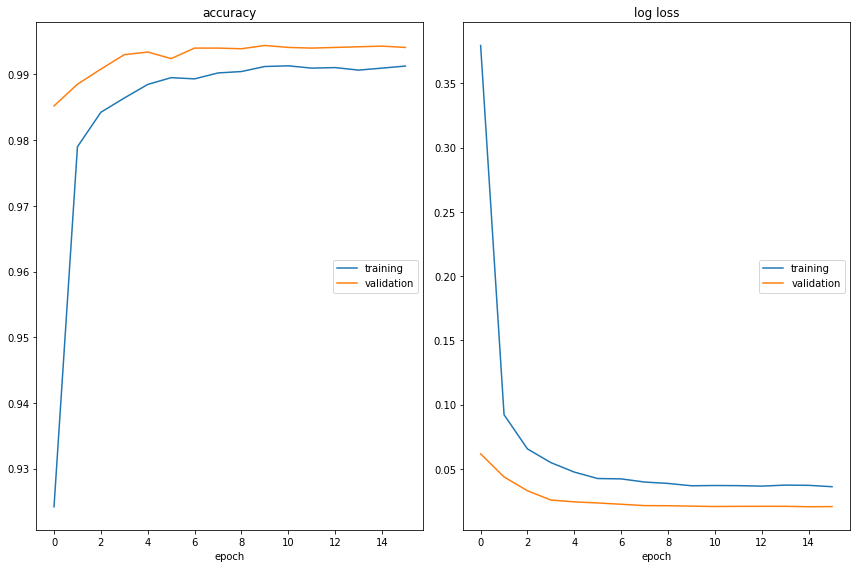

accuracy
	training         	 (min:    0.924, max:    0.991, cur:    0.991)
	validation       	 (min:    0.985, max:    0.994, cur:    0.994)
log loss
	training         	 (min:    0.036, max:    0.379, cur:    0.036)
	validation       	 (min:    0.020, max:    0.062, cur:    0.021)


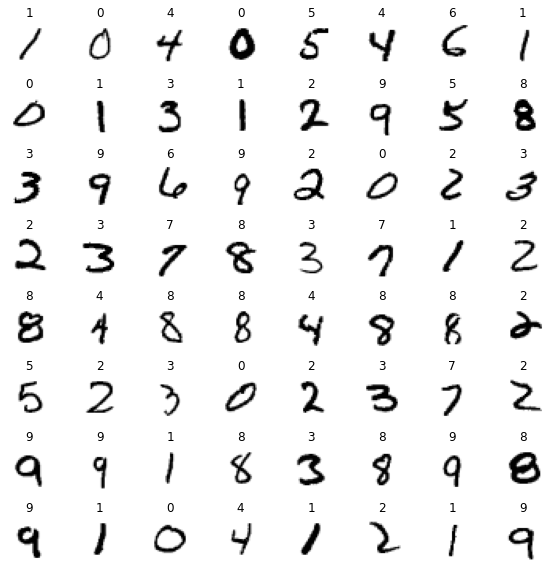


Correct prediction: 9941/10000 (99.41%)



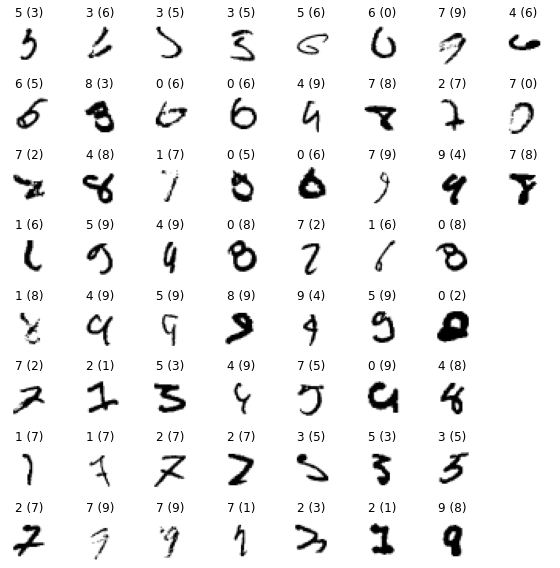


Wrong prediction: 59/10000 (0.59%)



In [6]:
sys.argv = ["", "--net=MyNet", "--batch-size=128", "--epochs=16", "--lr=0.1"]
main()

Another network is also tested. The network is posted on kaggle and anounced to have a 99.641% accuracy [5]. 

The CNN's original structure is `28x28-[32C5-P2]-[64C5-P2]-128-10`. However, Deotte has found through the experiments that the accuracy can be improved by replacing the `32C5` with two `32C3`. 

Furthermore, after each convolutional operation, batch nomalization and a 40% dropout is applied. 

The dropout technique randomly drop units and its connection during training, addressing the overfitting issue and improve the performance [6]. 

Batch normalization is used to reduce the epochs required to train a deep neural network, and stablize the training process [7].

In [7]:
class TheirNet(nn.Module):
    def __init__(self):
        super(TheirNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 32, 5, 2)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.4)
        self.conv4 = nn.Conv2d(32, 64, 3, 1)
        self.conv5 = nn.Conv2d(64, 64, 3, 1)
        self.conv6 = nn.Conv2d(64, 64, 5, 2)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(64, 128)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

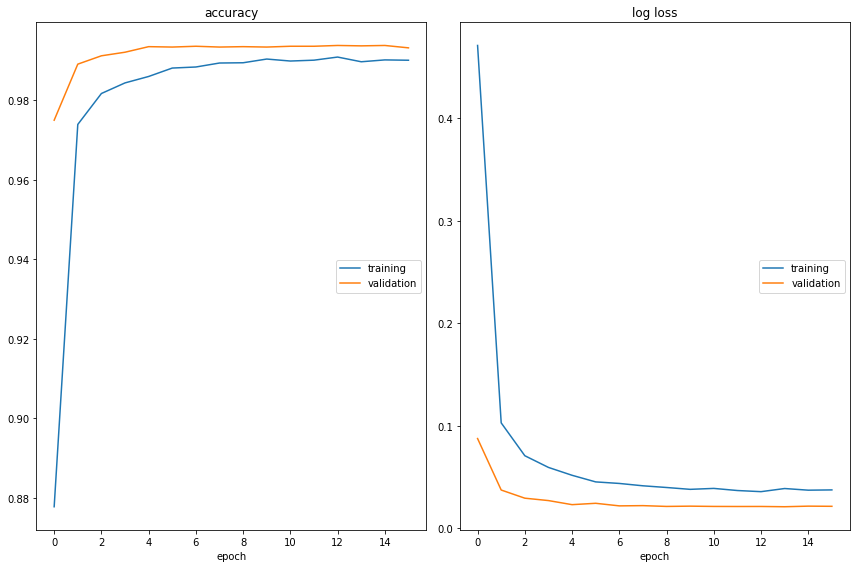

accuracy
	training         	 (min:    0.878, max:    0.991, cur:    0.990)
	validation       	 (min:    0.975, max:    0.994, cur:    0.993)
log loss
	training         	 (min:    0.036, max:    0.471, cur:    0.038)
	validation       	 (min:    0.021, max:    0.088, cur:    0.022)


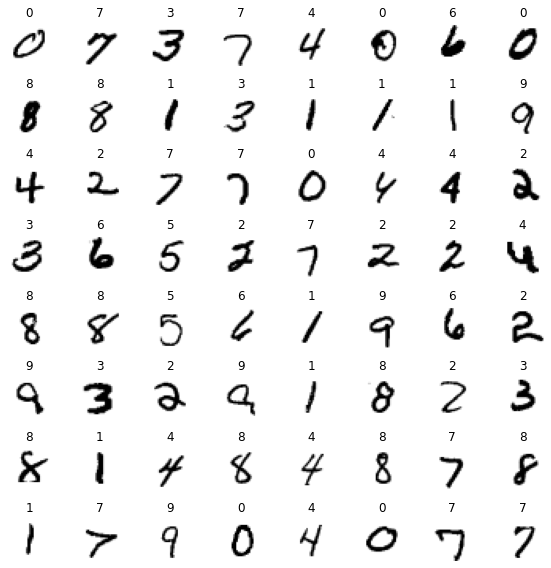


Correct prediction: 9932/10000 (99.32%)



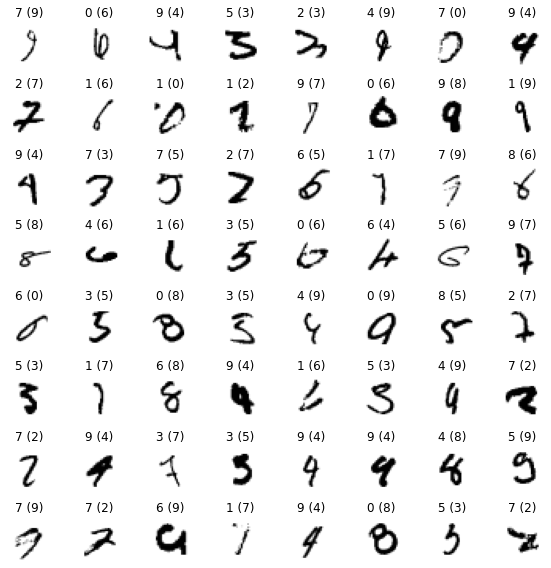


Wrong prediction: 68/10000 (0.68%)



In [8]:
sys.argv = ["", "--net=TheirNet", "--batch-size=128", "--epochs=16", "--lr=0.1"]
main()

The data augmentation and preprocessing are used in the original test, while in this test they are not implemented, which could be one explaination of the un-improved accuracy. 

## References

[1]	“Conv2d — PyTorch master documentation”. [Online]. Available at: https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html#torch.nn.Conv2d.

[2]	“NLLLoss — PyTorch master documentation”. [Online]. Available at: https://pytorch.org/docs/master/generated/torch.nn.NLLLoss.html?highlight=nll.

[3]	J. Brownlee, “Understand the Impact of Learning Rate on Neural Network Performance”, Sep-2020. [Online]. Available at: https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/.

[4]	A. Z. Karen Simonyan, “Very Deep Convolutional Networks for Large-Scale Image Recognition”, Apr 2015.

[5]	C. Deotte, “How to choose CNN Architecture MNIST | Kaggle”, undefined 2018. [Online]. Available at: https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist.

[6]	N. Srivastava, G. Hinton, A. Krizhevsky, I. Sutskever, en R. Salakhutdinov, “Dropout: A Simple Way to Prevent Neural Networks from Overfitting”, Journal of Machine Learning Research, vol 15, no 56, bll 1929–1958, 2014.

[7]	J. Brownlee, “A Gentle Introduction to Batch Normalization for Deep Neural Networks”, Jan-2019. [Online]. Available at: https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/.
